In [1]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix
from spin_reconstruction.hamiltonian import dipolar_hamiltonian, get_zeeman, mu_I1, mu_I2, mu_S
from spin_reconstruction.constants import *

from IPython.display import display

from labellines import labelLine, labelLines

%matplotlib widget

In [2]:
def first_cell_label(s):
    if s[2] == 1:
        letter = "E"
    else:
        match (s[0], s[1]):
            case (0,0):
                letter = "A"
            case (1,0):
                letter = "B"
            case (0,1):
                letter = "D"
            case (1,1):
                letter = "C"
            case _:
                raise ValueError("Not in first cell")
    match s[3]:
        case 0:
            site = "III"
        case 1:
            site = "II"
        case 2:
            site = "I"
        case 3:
            site = "II'"
    return f"{site}-{letter}"

In [3]:
first_cell_sites = np.array([
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,2],
    [0,0,0,3],
    [0,0,1,0],
    [0,1,0,1],
    [1,0,0,3],
    [1,0,0,2],
    [0,1,0,2],
    [1,1,0,2],
])

cell_sites = np.unique(np.array([
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,2],
    [0,0,0,3],
    [0,0,1,0],
    [0,1,0,1],
    [1,0,0,3],
    [1,0,0,2],
    [0,1,0,2],
    [1,1,0,2],

    [1,0,0,0],
    [1,0,0,1],
    [1,0,0,2],
    [1,0,0,3],
    [1,0,1,0],
    [1,1,0,1],
    [2,0,0,3],
    [2,0,0,2],
    [1,1,0,2],
    [2,1,0,2],

    [0,1,0,0],
    [0,1,0,1],
    [0,1,0,2],
    [0,1,0,3],
    [0,1,1,0],
    [0,2,0,1],
    [1,1,0,3],
    [1,1,0,2],
    [0,2,0,2],
    [1,2,0,2],

    [1,1,0,0],
    [1,1,0,1],
    [1,1,0,2],
    [1,1,0,3],
    [1,1,1,0],
    [1,2,0,1],
    [2,1,0,3],
    [2,1,0,2],
    [1,2,0,2],
    [2,2,0,2],

    [0,0,1,0],
    [0,0,1,1],
    [0,0,1,2],
    [0,0,1,3],
    [0,0,2,0],
    [0,1,1,1],
    [1,0,1,3],
    [1,0,1,2],
    [0,1,1,2],
    [1,1,1,2],

    [1,0,1,0],
    [1,0,1,1],
    [1,0,1,2],
    [1,0,1,3],
    [1,0,2,0],
    [1,1,1,1],
    [2,0,1,3],
    [2,0,1,2],
    [1,1,1,2],
    [2,1,1,2],

    [0,1,1,0],
    [0,1,1,1],
    [0,1,1,2],
    [0,1,1,3],
    [0,1,2,0],
    [0,2,1,1],
    [1,1,1,3],
    [1,1,1,2],
    [0,2,1,2],
    [1,2,1,2],

    [1,1,1,0],
    [1,1,1,1],
    [1,1,1,2],
    [1,1,1,3],
    [1,1,2,0],
    [1,2,1,1],
    [2,1,1,3],
    [2,1,1,2],
    [1,2,1,2],
    [2,2,1,2],
]), axis = 0)

first_cell_positions = lattice_x[None,:]*first_cell_sites[:,0][:,None] + lattice_y[None,:] * first_cell_sites[:,1][:,None] + lattice_z[None,:] * first_cell_sites[:,2][:,None] + lattice_s[first_cell_sites[:,3]]
cell_positions = lattice_x[None,:]*cell_sites[:,0][:,None] + lattice_y[None,:] * cell_sites[:,1][:,None] + lattice_z[None,:] * cell_sites[:,2][:,None] + lattice_s[cell_sites[:,3]]

In [4]:
theta = 0/180*np.pi
phi = 0/180*np.pi

B = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])

H_zeeman_erbium, H_zeeman_I1, H_zeeman_I2  = get_zeeman(B)

def get_hamiltonian(r1, r2):
    H_0 = (
        H_zeeman_erbium + 0.9*H_zeeman_I1 + H_zeeman_I2
        + dipolar_hamiltonian(mu_I1, mu_I2, r1 - r2)
    )
    V = (
        
        dipolar_hamiltonian(mu_I1, mu_S, r1 - erbium_position)
        + dipolar_hamiltonian(mu_I2, mu_S, r2 - erbium_position)
    )
    return H_0/h, V/h

In [32]:
def get_state(i):
    er = (i//4) == 1
    w1 = (i//2)%2 == 1
    w2 = i%2 == 1
    def bool_to_side(b):
        if b:
            return "up"
        else:
            return "down"
    return f"\\{bool_to_side(er).capitalize()}arrow \\{bool_to_side(w1)}arrow \\{bool_to_side(w2)}arrow"

def get_process(i):
    s = ""
    if (i//4) == 1:
        s += "S_x I_z^{(1)} + S_x I_z^{(2)}"
    if (i//2)%2 == 1:
        s += " I^{(1)}_x S_z"
    if i%2 == 1:
        s += " I^{(2)}_x S_z"
    return s.strip() if len(s) > 0 else "S_z I_z^{(1)} + S_z I_z^{(2)}"

In [33]:
def second_order_perturbation(H_0, V):
    H_0 = np.asmatrix(H_0)
    V = np.asmatrix(V)
    eig0, eigv0 = np.linalg.eigh(H_0)
    corrections = np.empty(H_0.shape)
    for i in range(H_0.shape[0]):
        corrections[i, i] = np.real(eigv0[:,i].H * V * eigv0[:,i]).item()
    for i in range(H_0.shape[0]):
        for j in range(H_0.shape[0]):
            if i == j:
                # First order
                continue
            else:
                corrections[i, j] = np.abs(eigv0[:,j].H * V * eigv0[:,i]).item()**2/np.real(eig0[i] - eig0[j]).item()
    return eig0, corrections

def get_Czz(eig):
    return eig[0] + eig[3] - eig[1] - eig[2]

def get_Czz_correction(corrections, process):
    return corrections[0, 0^process] + corrections[3, 3^process] - corrections[1, 1^process] - corrections[2, 2^process]

In [34]:
eigs = np.empty(len(cell_positions)*(len(cell_positions)-1)//2)
czz_approx = np.empty(len(cell_positions)*(len(cell_positions)-1)//2)
r1 = np.empty((len(cell_positions)*(len(cell_positions)-1)//2, 3))
r2 = np.empty((len(cell_positions)*(len(cell_positions)-1)//2, 3))
for i in range(len(cell_positions)):
    for j in range(i):
        H_0, V = get_hamiltonian(cell_positions[i], cell_positions[j])
        true_eig, _ = np.linalg.eigh(H_0 + V)
        eig0, corrections = second_order_perturbation(H_0, V)
        second_order_eig = np.sum(corrections, axis = 1) + eig0
        eigs[(i*(i-1))//2+j] = get_Czz(true_eig)
        czz_approx[(i*(i-1))//2+j] = get_Czz(np.sort(second_order_eig))
        r1[(i*(i-1))//2+j] = cell_positions[i] - erbium_position
        r2[(i*(i-1))//2+j] = cell_positions[j] - erbium_position

In [35]:
n = np.argmax(np.abs(czz_approx-eigs))

r1[n], r2[n], czz_approx[n], eigs[n]

(array([2.6215e-10, 0.0000e+00, 2.8440e-10]),
 array([-2.6215e-10,  0.0000e+00,  2.8440e-10]),
 np.float64(9.879979133605957),
 np.float64(10.018398761749268))

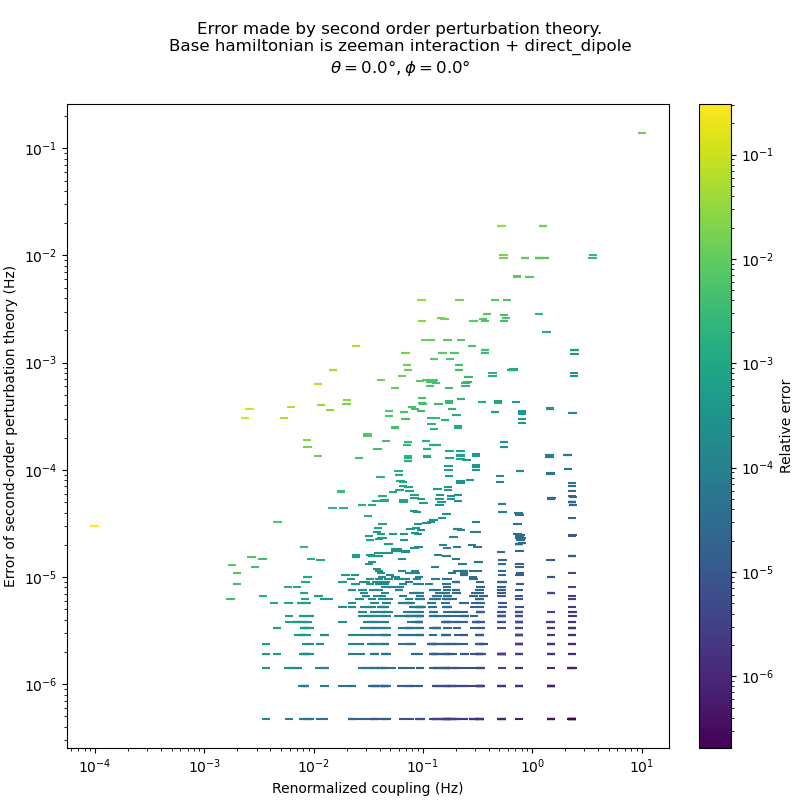

In [36]:
fig, ax = plt.subplots(1,figsize=(8,8),constrained_layout=True)

fig.suptitle(f"""
Error made by second order perturbation theory.
Base hamiltonian is zeeman interaction + direct_dipole
$\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
""")

sc = ax.scatter(np.abs(eigs), np.abs(czz_approx-eigs), c = np.abs(czz_approx-eigs)/np.abs(eigs), norm=LogNorm(), marker="_")

ax.set_xlabel("Renormalized coupling (Hz)")
ax.set_ylabel("Error of second-order perturbation theory (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")

cbar = fig.colorbar(sc)
cbar.set_label("Relative error")

pass

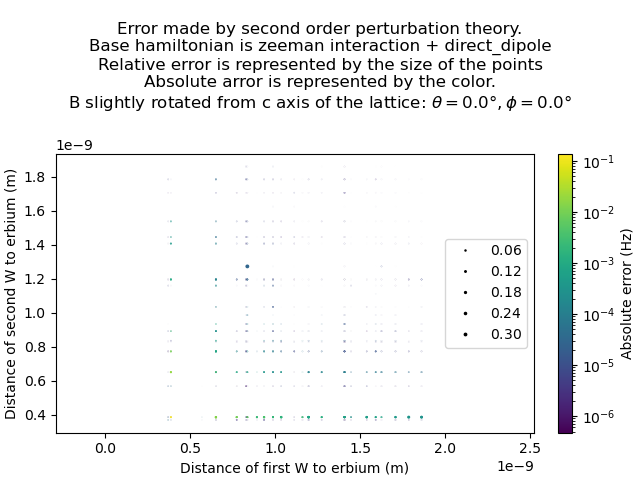

In [37]:
fig, ax = plt.subplots(1,constrained_layout=True)

fig.suptitle(f"""
Error made by second order perturbation theory.
Base hamiltonian is zeeman interaction + direct_dipole
Relative error is represented by the size of the points
Absolute arror is represented by the color.
B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
""")

sc = ax.scatter(np.linalg.norm(r1, axis=1), np.linalg.norm(r2, axis=1), s = np.abs(czz_approx-eigs)/np.abs(eigs)*1e1, c = np.abs(czz_approx-eigs), norm=LogNorm())

ax.legend(*sc.legend_elements("sizes", num=6, func=lambda x: x/1e1), loc="right")
ax.set_xlabel("Distance of first W to erbium (m)")
ax.set_ylabel("Distance of second W to erbium (m)")

cbar = fig.colorbar(sc)
cbar.set_label("Absolute error (Hz)")
ax.axis("equal")

pass

In [38]:
# Now let's understand who contributes to what

In [39]:
eigs = np.empty(len(first_cell_positions)*(len(first_cell_positions)-1)//2)
czz_approx = np.empty(len(first_cell_positions)*(len(first_cell_positions)-1)//2)
r1 = np.empty((len(first_cell_positions)*(len(first_cell_positions)-1)//2, 3))
r2 = np.empty((len(first_cell_positions)*(len(first_cell_positions)-1)//2, 3))
all_corrections = np.empty((len(first_cell_positions)*(len(first_cell_positions)-1)//2, corrections.shape[1]))
for i in range(len(first_cell_positions)):
    for j in range(i):
        H_0, V = get_hamiltonian(first_cell_positions[i], first_cell_positions[j])
        true_eig, _ = np.linalg.eigh(H_0 + V)
        eig0, corrections = second_order_perturbation(H_0, V)
        second_order_eig = np.sum(corrections, axis = 1) + eig0
        eigs[(i*(i-1))//2+j] = get_Czz(true_eig)
        czz_approx[(i*(i-1))//2+j] = get_Czz(second_order_eig)
        r1[(i*(i-1))//2+j] = first_cell_positions[i] - erbium_position
        r2[(i*(i-1))//2+j] = first_cell_positions[j] - erbium_position
        all_corrections[(i*(i-1))//2+j] = np.array([get_Czz_correction(corrections, i) for i in range(corrections.shape[1])])



/tmp/ipykernel_2509919/779933531.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


45

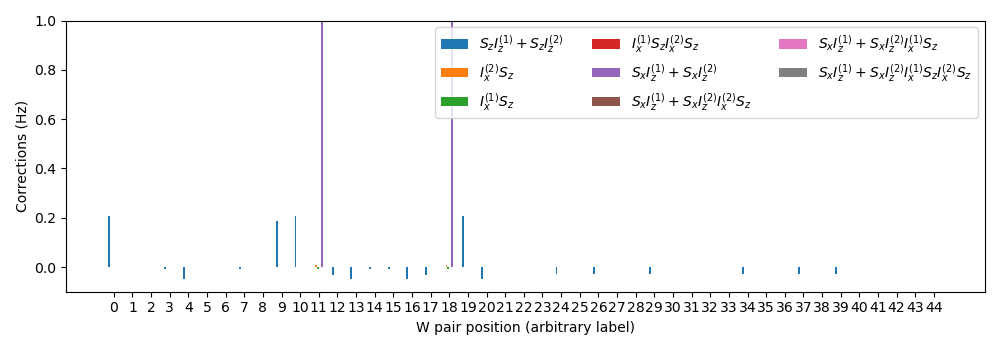

In [43]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
fig, ax = plt.subplots(figsize=(10,3.5),layout='constrained')
#ax.set_title("Second order perturbation corrections")

x = np.arange(len(all_corrections))  # the label locations
width = 0.1  # the width of the bars
offset = -3.5*width

for i in range(8):
    offset += width
    rects = ax.bar(x + offset, all_corrections[:,i], width, label=f"${get_process(i)}$")
    #ax.bar_label(rects, padding=3)

ax.set_ylabel('Corrections (Hz)')
#ax.set_yscale('log')
#ax.set_xticks(x, [f"{r1[i,0]:.0e} {r2[i,0]:.0e}\n{r1[i,1]:.0e} {r2[i,1]:.0e}\n{r1[i,2]:.0e} {r2[i,2]:.0e}" for i  in range(len(all_corrections))])
ax.set_xticks(x, range(len(all_corrections)))
#ax.set_title(f"""
#Second order perturbation theory corrections for different W positions by process
#Base hamiltonian is zeeman interaction + direct_dipole
#B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
#""")
ax.set_xlabel("W pair position (arbitrary label)")
ax.set_ylim(-0.1,1)
ax.legend(ncols=3)
fig.tight_layout()
fig.savefig("perturbation.svg")
len(all_corrections)

In [41]:
r1[11], r2[11]

(array([ 0.0000e+00,  2.6215e-10, -2.8440e-10]),
 array([ 0.0000e+00, -2.6215e-10, -2.8440e-10]))

In [44]:
eigs = np.empty(len(cell_positions)*(len(cell_positions)-1)//2)
czz_approx = np.empty(len(cell_positions)*(len(cell_positions)-1)//2)
r1 = np.empty((len(cell_positions)*(len(cell_positions)-1)//2, 3))
r2 = np.empty((len(cell_positions)*(len(cell_positions)-1)//2, 3))
all_corrections = np.empty((len(cell_positions)*(len(cell_positions)-1)//2, corrections.shape[1]))
for i in trange(len(cell_positions)):
    for j in range(i):
        H_0, V = get_hamiltonian(cell_positions[i], cell_positions[j])
        true_eig, _ = np.linalg.eigh(H_0 + V)
        eig0, corrections = second_order_perturbation(H_0, V)
        second_order_eig = np.sum(corrections, axis = 1) + eig0
        eigs[(i*(i-1))//2+j] = get_Czz(true_eig)
        czz_approx[(i*(i-1))//2+j] = get_Czz(second_order_eig)
        r1[(i*(i-1))//2+j] = cell_positions[i] - erbium_position
        r2[(i*(i-1))//2+j] = cell_positions[j] - erbium_position
        all_corrections[(i*(i-1))//2+j] = np.array([get_Czz_correction(corrections, i) for i in range(corrections.shape[1])])

  0%|          | 0/54 [00:00<?, ?it/s]

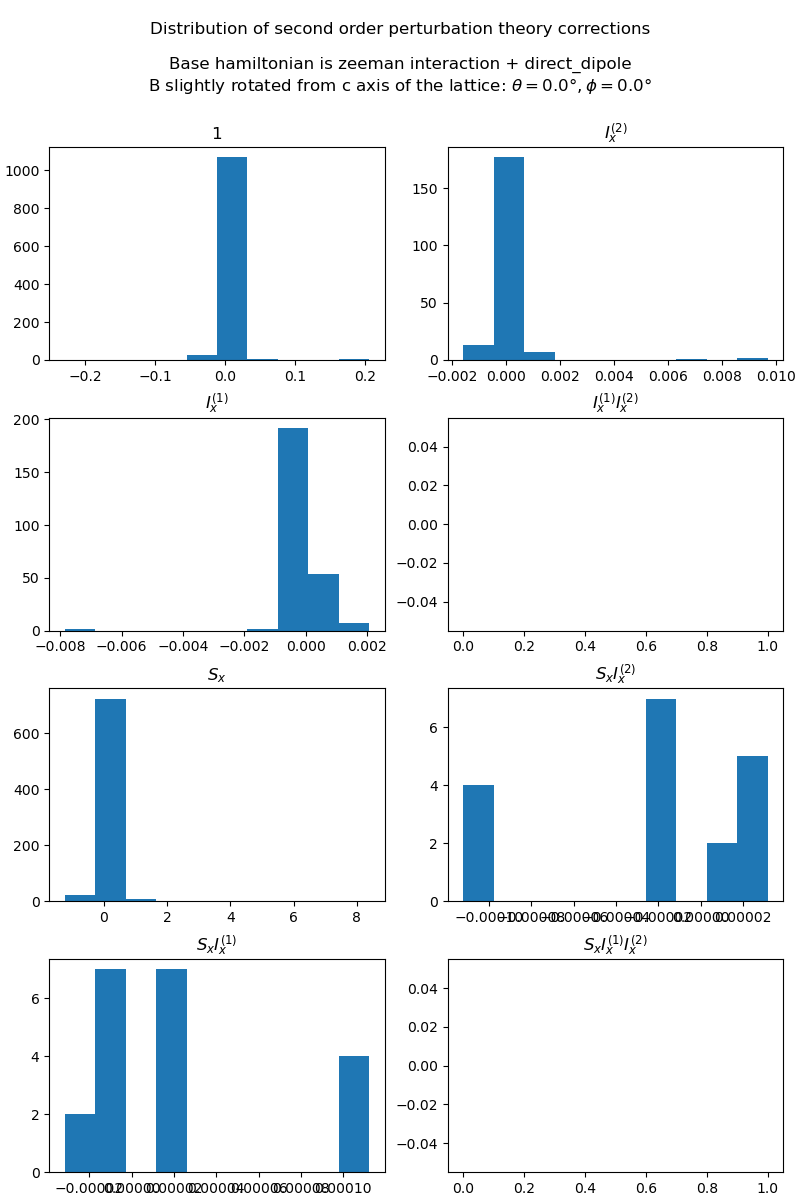

In [47]:
fig, ax = plt.subplots(4,2,figsize=(8,12), layout='constrained')
fig.suptitle(f"""
Distribution of second order perturbation theory corrections

Base hamiltonian is zeeman interaction + direct_dipole
B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
""")
for i in range(2):
    for j in range(4):
        ax[j,i].hist(all_corrections[:,i+j*2][np.abs(all_corrections[:,i+j*2])>1e-5])
        ax[j,i].set_title(f"${get_process(i+j*2)}$")


In [19]:
%timeit np.linalg.eigh(H_0+V)

412 μs ± 21.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
400e-6*(4*10**3)**2/60/32

3.3333333333333335